In [29]:
TASK_METRIC = {
    "cola": ["eval_matthews_correlation"],
    "mnli": ["matched_accuracy", "mismatched_accuracy"],
    "mrpc": ["eval_accuracy", "eval_f1"],
    "qnli": ["eval_accuracy"],
    "qqp": ["eval_accuracy", "eval_f1"],
    "rte": ["eval_accuracy"],
    "sst2": ["eval_accuracy"],
    "stsb": ["eval_pearson", "eval_spearman"],
    "wnli": ["eval_accuracy"],
}

METRIC_NAME_MAP = {
    'eval_matthews_correlation': 'Mcc',
    'matched_accuracy': 'm',
    'mismatched_accuracy': 'mm',
    'eval_accuracy': 'Acc',
    'eval_f1': 'F1',
    'eval_pearson': 'Corr_p',
    'eval_spearman': 'Corr_s',
}

TASK_NAME_MAP = {
    'mnli': 'MNLI',
    'sst2': 'SST-2',
    'cola': 'CoLA',
    'qqp': 'QQP',
    'qnli': 'QNLI',
    'rte': 'RTE',
    'mrpc': 'MRPC',
    'stsb': 'STS-B',
}

FAMILY_NAME_MAP = {
    'bert': 'BERT-b',
    'roberta': 'RoB-b',
    'deberta': 'DeB-b',
}

METHOD_NAME_MAP = {
    'lora': 'LoRA',
    'olora': 'OLoRA',
    'dora': 'DoRA',
    'mrlora': 'MR-LoRA',
    'adalora': 'AdaLoRA',
    'mrlora-rs': 'MR-LoRA-RS',
    'rslora': 'RS-LoRA'
}
VARIANT_NAME_MAP = {
    'fft': 'FFT',
    'lora': 'LoRA-Finetuning',
    'kd-lora': 'KD-LoRA-Finetuning'
}

REMOVE_PEFT = ['mrlora-rs']

In [30]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import  NA

def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./converge').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    # with open(json_file, 'w') as f:
    #     json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    print(peft_method)
    task = dictor(data, 'args.task')

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', NA)
    train_runtime = dictor(data, 'train.train_time', NA)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else NA

    rank = dictor(data, 'args.rank')
    if 'mrlora' in peft_method:
        rank = 2*rank - 1 # r = 2*R - 1
    
    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:

        eval_runtime_history = []
        for item in data['log_history']:
            if key in item:
                eval_runtime_history.append(round(item[key], 2))

        if eval_runtime_history:
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "history": eval_runtime_history,
                "value": data[key], # Final metric value.
                "metric": key,
                "rank": rank, # total rank.
                'seed': dictor(data, 'args.seed'),
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("metrics.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    return final_df

df = aggregate_experiment_results('./converge/')

mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
lora
lora
lora
lora
lora
lora
lora
lora
lora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora
mrlora-rs
mrlora


In [31]:
df

,family,peft,task,variant,history,value,metric,rank,seed
0,bert,mrlora-rs,cola,lora,"[0.05, 0.07, 0.35, 0.4, 0.41, 0.46, 0.47, 0.43...",0.517939,eval_matthews_correlation,7,42
1,bert,mrlora,cola,lora,"[-0.02, 0.0, 0.18, 0.42, 0.46, 0.44, 0.47, 0.4...",0.515374,eval_matthews_correlation,7,42
2,roberta,mrlora-rs,cola,lora,"[0.0, 0.0, 0.13, 0.35, 0.47, 0.5, 0.52, 0.51, ...",0.539126,eval_matthews_correlation,7,123
3,roberta,mrlora,cola,lora,"[0.0, 0.0, 0.0, 0.28, 0.44, 0.49, 0.5, 0.5, 0....",0.527031,eval_matthews_correlation,7,123
4,bert,mrlora-rs,cola,lora,"[0.0, 0.0, 0.08, 0.37, 0.37, 0.43, 0.41, 0.47,...",0.497026,eval_matthews_correlation,7,123
5,bert,mrlora,cola,lora,"[-0.02, 0.0, 0.0, 0.07, 0.36, 0.35, 0.35, 0.38...",0.469197,eval_matthews_correlation,7,123
6,deberta,mrlora-rs,cola,lora,"[0.0, 0.0, 0.57, 0.59, 0.59, 0.62, 0.65, 0.61,...",0.665160,eval_matthews_correlation,7,42
7,deberta,mrlora,cola,lora,"[0.0, 0.0, 0.0, 0.58, 0.59, 0.61, 0.6, 0.6, 0....",0.643058,eval_matthews_correlation,7,42
8,roberta,mrlora-rs,cola,lora,"[0.0, 0.0, 0.34, 0.41, 0.43, 0.48, 0.49, 0.45,...",0.546863,eval_matthews_correlation,7,42
9,roberta,mrlora,cola,lora,"[0.0, 0.0, 0.0, 0.4, 0.45, 0.42, 0.48, 0.47, 0...",0.536413,eval_matthews_correlation,7,42


In [ ]:
MODEL_FAMILY = 'bert'
TASK = 'cola'
METRIC = 'eval_matthews_correlation'
SEED = 42
RANK = 7

df = df[(df.variant == 'fft') | (df.peft == 'mrlora-rs')]
df = df[df.task == TASK]
# df = df[df.metric == METRIC]
df = df[df.family == MODEL_FAMILY]
df = df[df.seed == SEED] # Keep one seed
# df = df[df['rank'] == RANK]
df

,family,peft,task,variant,history,value,metric,rank,seed
0,bert,mrlora-rs,cola,lora,"[0.05, 0.07, 0.35, 0.4, 0.41, 0.46, 0.47, 0.43...",0.517939,eval_matthews_correlation,7,42
18,bert,lora,cola,fft,"[0.08, 0.49, 0.48, 0.49, 0.55, 0.55, 0.55, 0.5...",0.549470,eval_matthews_correlation,8,42
27,bert,mrlora-rs,cola,kd-lora,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.16, 0.24, 0....",0.046356,eval_matthews_correlation,7,42


In [33]:
def get_method_name(row):
    if row['variant'] == 'fft':
        return 'FFT'
    elif row['variant'] == 'lora':
        return f"MR"
    elif row['variant'] == 'kd-lora':
        return f"KD-MR"
    return row['variant']

df['Method'] = df.apply(get_method_name, axis=1)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置为 'talk' 模式，这会自动放大所有元素，非常接近论文插图的需求
sns.set_context("talk") 

# 或者手动精细调整
plt.rcParams.update({
    "font.family": "serif",  # 论文通常使用衬线字体
    "font.serif": ["Times New Roman"], # 匹配 LaTeX 默认字体
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.figsize": (8, 6) # 控制画布大小，画布越小，相对字号就越大
})

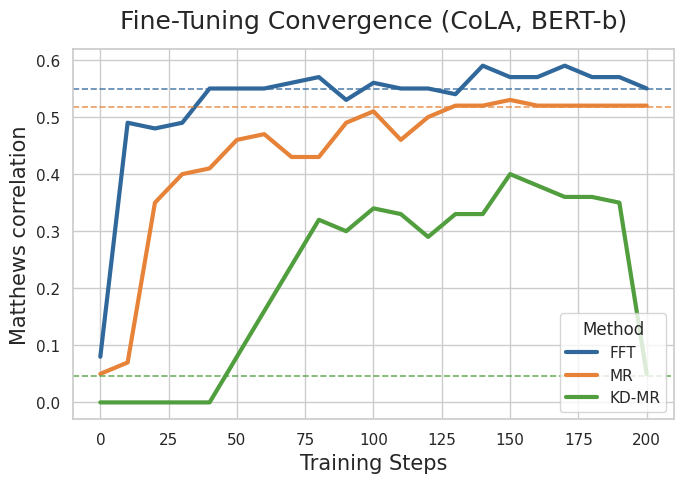

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Generate Dummy Data
def generate_demo_history(final_val, noise=0.02):
    # Creates an exponential-like convergence curve
    steps = 11  # 0 to 100 steps (every 10)
    x = np.linspace(0, 1, steps)
    history = final_val * (1 - np.exp(-5 * x)) 
    # Add a bit of random noise for realism
    history += np.random.normal(0, noise, steps)
    history[0] = 0 # Start at 0
    return history.tolist()

# data = [
#     {'Method': 'FFT', 'value': 0.58, 'history': generate_demo_history(0.58)},
#     {'Method': 'MR',  'value': 0.56, 'history': generate_demo_history(0.56)},
#     {'Method': 'KD',  'value': 0.54, 'history': generate_demo_history(0.54)},
# ]
# df = pd.DataFrame(data)

# 2. Setup Figure Style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5)) # Smaller figsize makes text look relatively larger

# 3. Process Data for Plotting
plot_rows = []
for _, row in df.iterrows():
    for i, val in enumerate(row['history']):
        plot_rows.append({
            'Method': row['Method'],
            'Steps': i * 10,
            'Metric': val
        })
history_df = pd.DataFrame(plot_rows)

# 4. Define Color Palette
palette = {'FFT': '#31689b', 'MR': '#e68339', 'KD-MR': '#519e3e'}
target_order = ['FFT', 'MR', 'KD-MR']

# 5. Plot Curves and Baselines
ax = sns.lineplot(data=history_df, x='Steps', y='Metric', hue='Method', 
                  palette=palette,
    hue_order=target_order, # This forces the legend order
                   linewidth=3)

for _, row in df.iterrows():
    plt.axhline(y=row['value'], color=palette[row['Method']], 
                linestyle='--', linewidth=1.2, alpha=0.8)

# 6. Professional Formatting
task_name = TASK_NAME_MAP[TASK]
family_name = FAMILY_NAME_MAP[MODEL_FAMILY]
plt.title(f'Fine-Tuning Convergence ({task_name}, {family_name})', fontsize=18, pad=15)
plt.xlabel('Training Steps', fontsize=15)
plt.ylabel('Matthews correlation', fontsize=15)
# plt.ylim(-0.05, 0.65) # Adjust range to match reference

# Move legend to a clear spot
plt.legend(title='Method', loc='lower right', frameon=True)

plt.tight_layout()
# 7. Save and Show
plt.savefig(f'./MrLoRA/figures/converge-{family_name}.pdf', bbox_inches='tight')

Deberta is normal, other two kd has shark drop at last.